# Stock Predictor

In [1]:
# might need updata yfinance to the latest to scrape the data successfully
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
#Import relevent packages

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Getting Data through API 

In [4]:
#Define the stock ticker and pull the historical data from a start date
ticker=yf.Ticker('AAPL')
start=dt.datetime(2011, 1, 1)
end=dt.datetime.now()

data=ticker.history(start=start, end=end, interval="1d")
print('The shape of the data is ', data.shape)
data.tail()

The shape of the data is  (2652, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-12,146.210007,146.320007,144.000000,144.500000,76299700,0.0,0.0
2021-07-13,144.029999,147.460007,143.630005,145.639999,100698900,0.0,0.0
2021-07-14,148.100006,149.570007,147.679993,149.149994,127050800,0.0,0.0
2021-07-15,149.240005,150.000000,147.089996,148.479996,106820300,0.0,0.0
2021-07-16,148.460007,149.759995,145.880005,146.389999,93100300,0.0,0.0


# Data Preprocess and Visualization

In [5]:
#Select the daily closing price and normalize the data to (0,1)

data_close=data.Close.values.reshape(-1,1)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data_close)
scaled_data

array([[0.0031379 ],
       [0.00351664],
       [0.0041134 ],
       ...,
       [1.        ],
       [0.99519598],
       [0.98021031]])

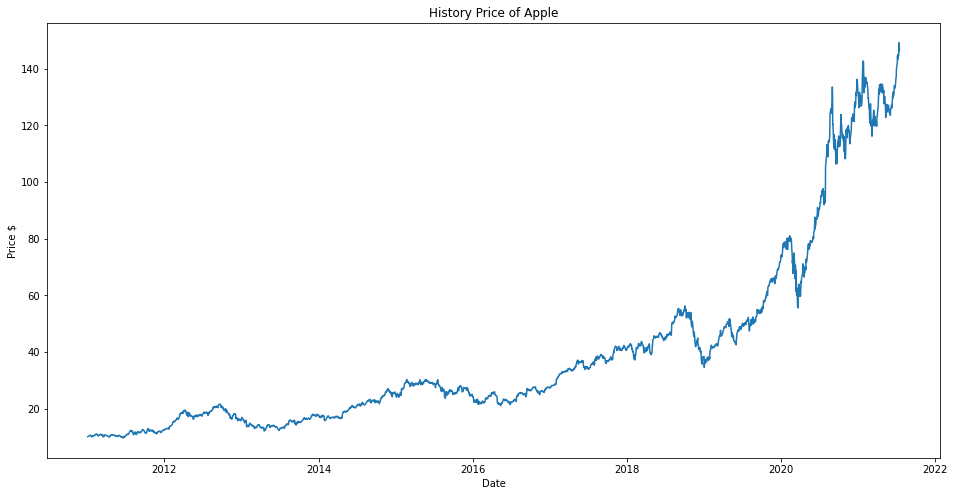

In [6]:
#Visualize the historical data

plt.figure(figsize=(16, 8))
plt.title('History Price of Apple')
plt.plot(data.Close)
plt.xlabel('Date')
plt.ylabel('Price $')
plt.show()

# Prepare Data for Different Training Models

In [7]:

def train_test_split_lstm(data, prediction_days, train_size=0.9):
    
    '''Split train and test data for RNN model
    
    Split train and test data according to the ratio in time order
    
    Args:
        data is the preprocessed historical data
        prediction_days is the number of historical data to use as input
        train_size is the ratio of training set
        
    Returns:
        input and label for training set and test set
        
    '''
    
    n_train=int(len(data)*train_size)
    x_train, y_train, x_test, y_test=[], [], [], []
    
    for i in range(prediction_days, n_train):
        x_train.append(data[i-prediction_days:i, 0])
        y_train.append(data[i, 0])
    
    for j in range(n_train, len(data)):
        x_test.append(data[j-prediction_days:j, 0])
        y_test.append(data[j, 0])
    
    x_train, y_train=np.array(x_train), np.array(y_train)
    x_test, y_test=np.array(x_test), np.array(y_test)
    x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test
    

In [8]:
# Train test split for RNN model

prediction_days=60 # number of days used as input

x_train, y_train, x_test, y_test=train_test_split_lstm(scaled_data, prediction_days)

print('x_train has {} samples, x_test has {} samples'.format(x_train.shape[0], x_test.shape[0]))

x_train has 2326 samples, x_test has 266 samples


In [9]:
# Train test split for regression model

# number of historical data as input
num_days=252
# predict the stock price of future days
future_days=1
# get historical data
data_reg=data_close[-num_days:]
X=data_reg[:-future_days]
y=data_reg[future_days:]

# train test split and future data, set shuffle to false
x_train1, x_test1, y_train1, y_test1=train_test_split(X, y, test_size=0.2, shuffle=False)
x_future=X[-future_days:]

# Regression Model

Build regression model using the data from the previous year from now. 

In [10]:
# DecisionTree, LinearRegression, SVM model
dt=DecisionTreeRegressor().fit(x_train1, y_train1)
lr=LinearRegression().fit(x_train1, y_train1)
svm=SVR(kernel='poly').fit(x_train1, y_train1.ravel())

# evaluate the performance of the model on training set
print('For training set: ')
print('Linear      : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, lr.predict(x_train1)),\
                                                                     r2_score(y_train1, lr.predict(x_train1))))
print('DecisionTree: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, dt.predict(x_train1)),\
                                                                     r2_score(y_train1, dt.predict(x_train1))))
print('SVM         : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, svm.predict(x_train1)),\
                                                                     r2_score(y_train1, svm.predict(x_train1))))

# make predictions on the testset
dt_pred=dt.predict(x_test1)
lr_pred=lr.predict(x_test1)
svm_pred=svm.predict(x_test1)

# evaluate the performance of the model on test set
print('For test set: ')
print('Linear      : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, lr_pred),\
                                                                     r2_score(y_test1, lr_pred)))
print('DecisionTree: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, dt_pred),\
                                                                     r2_score(y_test1, dt_pred)))
print('SVM         : mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, svm_pred),\
                                                                     r2_score(y_test1, svm_pred)))

For training set: 
Linear      : mean square error is 7.42564237739515, r2_score is 0.9283503564412529
DecisionTree: mean square error is 0.053481502647046, r2_score is 0.999483959715955
SVM         : mean square error is 9.163661591428728, r2_score is 0.9115802979257978
For test set: 
Linear      : mean square error is 3.271674617841357, r2_score is 0.9408467022367442
DecisionTree: mean square error is 11.360593650317705, r2_score is 0.7945955336450934
SVM         : mean square error is 3.881256057662489, r2_score is 0.92982520510373


**Display the test prediction (recent stock price)**

In [11]:
data_future=data[-len(x_test1):]
data_future['dt prediction']=dt_pred
data_future['lr prediction']=lr_pred
data_future['svm prediction']=svm_pred
data_future=data_future[['Close', 'dt prediction', 'lr prediction', 'svm prediction']]
data_future.tail()

C:\Users\Micluan\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Micluan\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Micluan\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Close,dt prediction,lr prediction,svm prediction
Date,,,,
2021-07-12,144.500000,141.607513,144.066789,147.597897
2021-07-13,145.639999,141.607513,143.487771,146.791286
2021-07-14,149.149994,141.607513,144.569869,148.304250
2021-07-15,148.479996,141.607513,147.901588,153.113296
2021-07-16,146.389999,141.607513,147.265619,152.177601


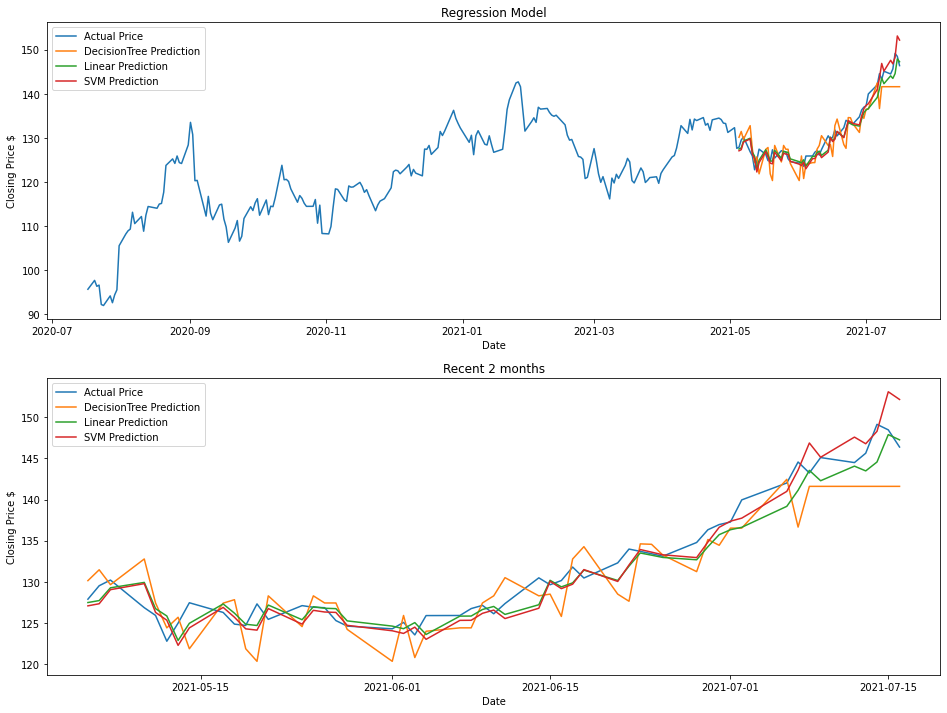

In [12]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.title('Regression Model')
plt.plot(data.Close[-num_days:])
plt.plot(data_future['dt prediction'])
plt.plot(data_future['lr prediction'])
plt.plot(data_future['svm prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'DecisionTree Prediction', 'Linear Prediction', 'SVM Prediction'])

plt.subplot(2, 1, 2)
plt.title('Recent 2 months')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['dt prediction'])
plt.plot(data_future['lr prediction'])
plt.plot(data_future['svm prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'DecisionTree Prediction', 'Linear Prediction', 'SVM Prediction'])
plt.show()

## Gridsearch to optimize parameters

In [13]:
# Optimize parameters for DecisionTree Regression

model=DecisionTreeRegressor()
parameters={'max_depth': (None, 2, 3, 5, 8),
            'criterion': ('mse', 'mae'),
            'splitter': ('best', 'random')
           }

cv_dt=GridSearchCV(model, param_grid=parameters,verbose=3)
cv_dt.fit(x_train1, y_train1)
cv_dt_pred=cv_dt.predict(x_test1)

print('The best parameter set: ', cv_dt.best_params_)
print('Trainset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, cv_dt.predict(x_train1)),\
                                                                     r2_score(y_train1, cv_dt.predict(x_train1))))
print('Testset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, cv_dt_pred),\
                                                                     r2_score(y_test1, cv_dt_pred)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=mse, max_depth=None, splitter=best;, score=0.492 total time=   0.0s
[CV 2/5] END criterion=mse, max_depth=None, splitter=best;, score=0.319 total time=   0.0s
[CV 3/5] END criterion=mse, max_depth=None, splitter=best;, score=0.680 total time=   0.0s
[CV 4/5] END criterion=mse, max_depth=None, splitter=best;, score=0.613 total time=   0.0s
[CV 5/5] END criterion=mse, max_depth=None, splitter=best;, score=0.481 total time=   0.0s
[CV 1/5] END criterion=mse, max_depth=None, splitter=random;, score=0.489 total time=   0.0s
[CV 2/5] END criterion=mse, max_depth=None, splitter=random;, score=0.197 total time=   0.0s
[CV 3/5] END criterion=mse, max_depth=None, splitter=random;, score=0.629 total time=   0.0s
[CV 4/5] END criterion=mse, max_depth=None, splitter=random;, score=0.573 total time=   0.0s
[CV 5/5] END criterion=mse, max_depth=None, splitter=random;, score=0.303 total time=   0.0s
[CV 1/5] END crite

In [14]:
# Optimize parameters for SVM Regression
model=SVR()
print(model.get_params())
parameters={'kernel': ('poly', 'rbf', 'sigmoid'),
            'C': (0.0001, 0.001, 0.01, 0.1, 1.0)         
           }

cv_svm=GridSearchCV(model, param_grid=parameters, verbose=3)
cv_svm.fit(x_train1, y_train1.ravel())
cv_svm_pred=cv_svm.predict(x_test1)

print('The best parameter set: ', cv_svm.best_params_)
print('Trainset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train1, cv_svm.predict(x_train1)),\
                                                                     r2_score(y_train1, cv_svm.predict(x_train1))))
print('Testset: mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test1, cv_svm_pred),\
                                                                     r2_score(y_test1, cv_svm_pred)))

{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .............C=0.0001, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/5] END .............C=0.0001, kernel=poly;, score=0.469 total time=   0.0s
[CV 3/5] END .............C=0.0001, kernel=poly;, score=0.838 total time=   0.0s
[CV 4/5] END .............C=0.0001, kernel=poly;, score=0.789 total time=   0.0s
[CV 5/5] END .............C=0.0001, kernel=poly;, score=0.839 total time=   0.0s
[CV 1/5] END .............C=0.0001, kernel=rbf;, score=-0.915 total time=   0.0s
[CV 2/5] END .............C=0.0001, kernel=rbf;, score=-6.552 total time=   0.0s
[CV 3/5] END .............C=0.0001, kernel=rbf;, score=-0.229 total time=   0.0s
[CV 4/5] END .............C=0.0001, kernel=rbf;, score=-2.954 total time=   0.0s
[CV 5/5] END .............C=0.0001,

## Final prediction for the next day stock price

In [15]:
# Predict the stock price for the next day

x_next_day=data_reg[-future_days].reshape(-1,1)
lr_next_day=lr.predict(x_next_day)
dt_next_day=cv_dt.predict(x_next_day)
svm_next_day=cv_svm.predict(x_next_day)
print('Next day prediction by Linear model is ', lr_next_day)
print('Next day prediction by DecisionTree model is ', dt_next_day)
print('Next day prediction by SVM model is', svm_next_day)


Next day prediction by Linear model is  [[145.28177561]]
Next day prediction by DecisionTree model is  [142.15576172]
Next day prediction by SVM model is [149.31262832]


# RNN model

In [16]:
# LSTM model parameters

lstm_size=32
input_size=(x_train.shape[1], x_train.shape[2])
dropout=0.2
dense_size=20

In [17]:
# build LSTM model and train the model for 20 epochs

def create_model(lstm_size=32, dropout=0.2, dense_size=20):
    
    model=Sequential()
    model.add(LSTM(units=lstm_size, return_sequences=True, input_shape=input_size))
    model.add(Dropout(dropout))
    model.add(LSTM(units=lstm_size, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=dense_size))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

model=create_model(lstm_size, dropout, dense_size)
model.summary()
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 13,353
Trainable params: 13,353
Non-trainable params: 0
____________________________________________________

In [18]:
y_pred=model.predict(x_test)

y_fit=model.predict(x_train)
y_fit_price=scaler.inverse_transform(y_fit)
y_train_price=scaler.inverse_transform(y_train.reshape(-1,1))
y_test_price=scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_price=scaler.inverse_transform(y_pred)

print('For training set: ')
print('mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train_price, y_fit_price),\
                                                       r2_score(y_train_price, y_fit_price)))
print('For test set: ')
print('mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test_price, y_pred_price),\
                                                       r2_score(y_test_price, y_pred_price)))


For training set: 
mean square error is 1.5866179775141112, r2_score is 0.994399756766829
For test set: 
mean square error is 33.62397117220492, r2_score is 0.7814464592071995


### This Cell below takes long time to run. Try reduce the number of variables in the parameters dict

In [182]:
# Optimize parameters for LSTM model
lstm=KerasRegressor(build_fn=create_model, epochs=20, batch_size=64, verbose=0)
parameters = {'lstm_size': ([20, 32, 64]) , #64 (20, 32, 64)
              'dropout': ([0.2, 0.3, 0.5]), #0.2 (0.2, 0.3, 0.5)
              'dense_size': (50, 20, 10)} #10

cv_lstm=GridSearchCV(lstm, parameters, verbose=3)
cv_lstm.fit(x_train, y_train)
cv_lstm_pred=cv_lstm.predict(x_test).reshape(-1,1)

y_pred_price=scaler.inverse_transform(cv_lstm_pred)

y_fit=cv_lstm.predict(x_train).reshape(-1,1)
y_fit_price=scaler.inverse_transform(y_fit)
y_train_price=scaler.inverse_transform(y_train.reshape(-1,1))
y_test_price=scaler.inverse_transform(y_test.reshape(-1,1))


print('The best parameter set: ', cv_lstm.best_params_)
print('For training set: ')
print('mean square error is {}, r2_score is {}'.format(mean_squared_error(y_train_price, y_fit_price),\
                                                       r2_score(y_train_price, y_fit_price)))
print('For test set: ')
print('mean square error is {}, r2_score is {}'.format(mean_squared_error(y_test_price, y_pred_price),\
                                                       r2_score(y_test_price, y_pred_price)))



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END dense_size=50, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 2/5] END dense_size=50, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 3/5] END dense_size=50, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 4/5] END dense_size=50, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 5/5] END dense_size=50, dropout=0.2, lstm_size=64;, score=-0.001 total time= 1.5min
[CV 1/5] END dense_size=20, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 2/5] END dense_size=20, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 3/5] END dense_size=20, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 4/5] END dense_size=20, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.5min
[CV 5/5] END dense_size=20, dropout=0.2, lstm_size=64;, score=-0.000 total time= 1.7min
[CV 1/5] END dense_size=10, dropout=0.2, lstm_size=64;, scor

**LSTM performance**

C:\Users\Micluan\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


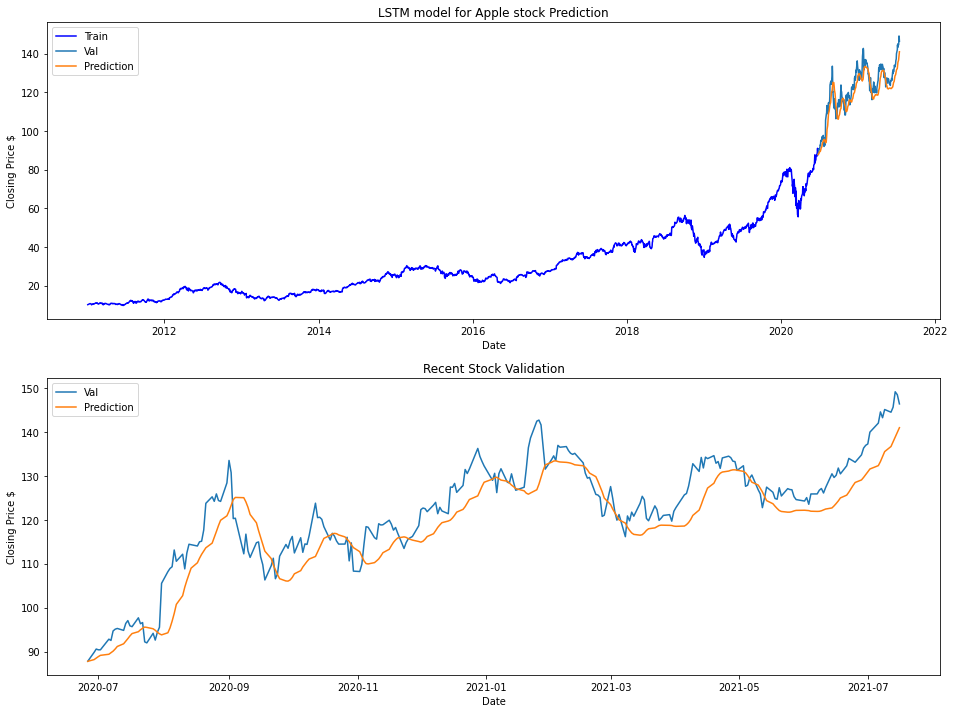

In [19]:
# Visualize predicted price and actual price
n_train=x_train.shape[0]+prediction_days
train=data.iloc[:n_train, :]
valid=data.iloc[n_train:, :]
valid['Prediction']=y_pred_price

plt.figure(figsize=(16, 12))
plt.subplot(2,1,1)
plt.title('LSTM model for Apple stock Prediction')
plt.plot(train['Close'], color='blue')
plt.plot(valid[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Train', 'Val', 'Prediction'])

plt.subplot(2,1,2)
plt.title('Recent Stock Validation')
plt.plot(valid[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend([ 'Val', 'Prediction'])
plt.show()

**Plot recent stock prediction and compare with actual price**

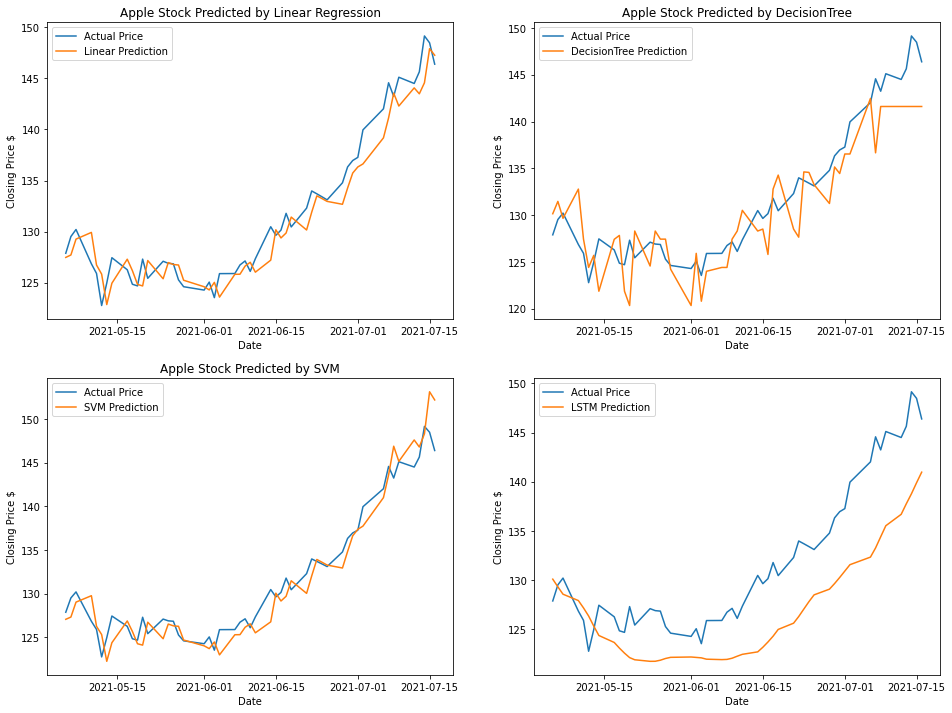

In [20]:
# Compare all models on the test set
plt.figure(figsize=(16, 12))

plt.subplot(2,2,1)
plt.title('Apple Stock Predicted by Linear Regression')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['lr prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'Linear Prediction'])

plt.subplot(2,2,2)
plt.title('Apple Stock Predicted by DecisionTree')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['dt prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'DecisionTree Prediction'])

plt.subplot(2,2,3)
plt.title('Apple Stock Predicted by SVM')
plt.plot(data.Close[-len(y_test1):])
plt.plot(data_future['svm prediction'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'SVM Prediction'])

plt.subplot(2,2,4)
plt.plot(data.Close[-len(y_test1):])
plt.plot(valid['Prediction'][-len(y_test1):])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend(['Actual Price', 'LSTM Prediction'])

plt.show()


**LSTM next day prediction**

In [21]:
next_day=[scaled_data[len(scaled_data)-prediction_days:,0]]
next_day=np.array(next_day)
next_day=np.reshape(next_day, (next_day.shape[0], next_day.shape[1], 1))

In [22]:
pred_next_day=model.predict(next_day)
pred_next_day=scaler.inverse_transform(pred_next_day)
print('The prediction for next day is ', pred_next_day[0][0])

The prediction for next day is  141.81996
